In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import positioner as ps
import IPython 
import numpy as np
from matplotlib import pyplot

This notebook presents an estimate of the number of positioner collisions per pointing.

The positioner's geometry is defined from the DESIDoc 8999 v2. Images are taken from the same doc.

There are three types of collisions.

1. Type I: No collision.
2. Type II: The two upper arms (fiber holders) collide
3. Type III: The upper arm of A collides with the body of B.


Example of Type 2 collision

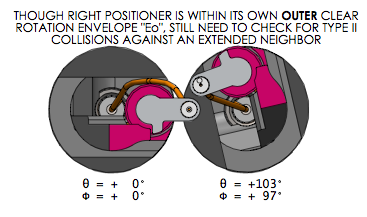

In [3]:
IPython.display.Image("../img/type2_collision.png")

Example of Type 2 collision

Example of Type 3 collision.

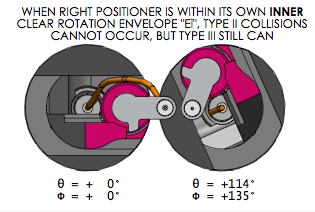

In [4]:
IPython.display.Image("../img/type3_collision.png")

To find the angle between the black line and the axis of symmetry we solve a triangle with known sides.

# Test on poissonian targets

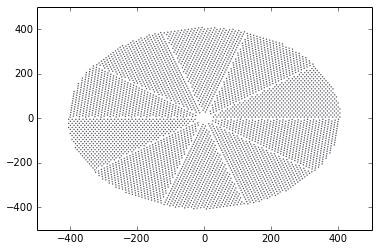

In [5]:
positioner_file = "../../surveyplan/data/pos_on_z1.txt"
positioner_data = np.loadtxt(positioner_file)
x_pos = positioner_data[:,1]
y_pos = positioner_data[:,2]
z_pos = positioner_data[:,3]
pyplot.scatter(x_pos, y_pos, s=0.1)
n_pos = np.size(x_pos)
R1 = 3.0
R2 = 3.0
patrol_radius = R1+R2

In [6]:
def gen_targets(n_pos=5000):
    n_targets = n_pos * 5
    theta_rand = 2.0 * np.pi * np.random.random(n_targets)
    r_rand = 160000.0* np.random.random(n_targets)
    x_t = np.sqrt(r_rand) * np.sin(theta_rand)
    y_t = np.sqrt(r_rand) * np.cos(theta_rand)
    return x_t, y_t

In [8]:
def assign_positioner(x_pos, y_pos, x_t, y_t):
    n_pos = np.size(x_pos)
    n_targets = np.size(x_t)
    x_on_t = np.zeros(n_pos)
    y_on_t = np.zeros(n_pos)
    target_available = np.zeros(n_targets)
    for i in range(n_pos):
        x_pos_i = x_pos[i]
        y_pos_i = y_pos[i]
    
        distance = np.sqrt((x_t-x_pos_i)**2 + (y_t - y_pos_i)**2)
        reachable = np.where((distance<patrol_radius)&(target_available==0))
        reachable = reachable[0]
        n_reachable = np.size(reachable)
    
        if (n_reachable):
            x_on_t[i] = x_target[reachable[0]]
            y_on_t[i] = y_target[reachable[0]]
            target_available[reachable[0]] = -1
        else:
            x_on_t[i] = x_pos_i
            y_on_t[i] = y_pos_i
    return x_on_t, y_on_t


In [9]:
def find_theta_phi(x_pos, y_pos, x_on_t, y_on_t):
    #amount on x and y that each fiber has to move to reach the target
    x_move = x_on_t - x_pos
    y_move = y_on_t - y_pos

    #the corresponding Theta and Phi for each positioner
    r = np.sqrt(x_move**2 + y_move**2) + 1E-12
    cos_alpha = (R2*R2 + R1*R1 - r*r)/(2.0*R2*R1)
    cos_beta = (R1*R1 + r*r - R2*R2)/(2.0*R1*r)
    cos_gamma = (r*r + R2*R2 - R1*R1)/(2.0*r*R2)
    cos_delta = x_move/r

    P = cos_alpha.copy()
    T = cos_alpha.copy()
    P[:] = np.inf
    T[:] = np.inf

    good = np.where(np.abs(cos_gamma)<=1.0)

    T[good] = 2.0*np.pi - np.arccos(cos_beta[good]) - np.arccos(cos_delta[good])
    P[good] = np.pi - np.arccos(cos_alpha[good])

    positive_y = np.where((y_move>=0.0) & (np.abs(cos_gamma)<=1.0))
    T[positive_y] = np.arccos(cos_delta[positive_y]) - np.arccos(cos_beta[positive_y])

    P[good] = np.rad2deg(P[good])
    T[good] = np.rad2deg(T[good])
    return T, P


In [15]:
n_layers = 20
n_colls = np.zeros(n_layers)

for layer in range(n_layers):
    #generate targets and do the allocation
    x_target, y_target = gen_targets(n_pos=n_pos)
    x_on_target, y_on_target = assign_positioner(x_pos, y_pos, x_target, y_target)
    T,P = find_theta_phi(x_pos, y_pos, x_on_target, y_on_target)

    #generate the positioners on their final target positions
    pos_list = []
    for i in range(n_pos):
        pos_list.append(ps.positioner(offset_x=x_pos[i], offset_y=y_pos[i],Theta=T[i], Phi=P[i]))
    
    #check for collisions, both type II and III
    n_collision = 0
    for i in range(n_pos):
        x_pos_i = x_pos[i]
        y_pos_i = y_pos[i]
        distance = np.sqrt((x_pos-x_pos_i)**2 + (y_pos - y_pos_i)**2)
        reachable = np.where(distance<patrol_radius*2.1)
        reachable = reachable[0]
        n_reachable = np.size(reachable)
        #we only check for collisions with neighboring positioners
        for j in reachable:
            if(i!=j):
                a, b = ps.find_collision_type(pos_list[i], pos_list[j])
                if(a|b):
                    n_collision = n_collision + 1   
    print n_collision
    n_colls[layer] = n_collision

584
568
588
632
570
610
664
624
596
594
604
532
578
558
638
622
624
574
620
638


In [33]:
print("%f percent of positioners are colliding (on average)"%(np.average(100.0*n_colls/n_pos)))

11.467557 percent of positioners are colliding (on average)


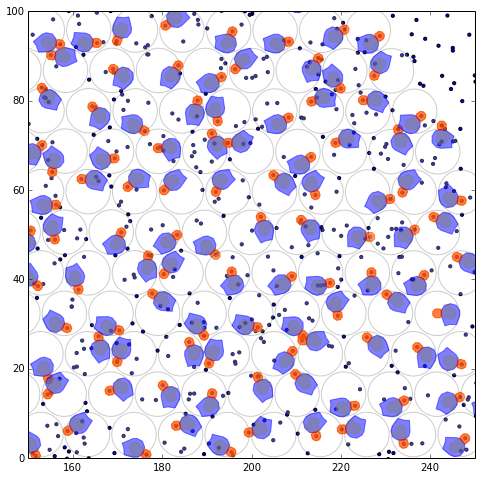

In [35]:
fig, ax = pyplot.subplots(figsize=(8, 8))
ax.set_xlim(150,250)
ax.set_ylim(0,100)
for i in range(200):
    ps.add_plot_positioner(pos_list[i], ax=ax)
pyplot.scatter(x_target, y_target, s=10)

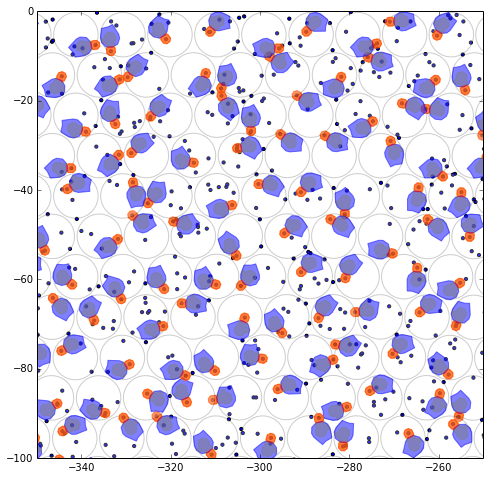

In [36]:
fig, ax = pyplot.subplots(figsize=(8, 8))
ax.set_xlim(-350,-250)
ax.set_ylim(-100,0)
for i in range(2700,3400):
    ps.add_plot_positioner(pos_list[i], ax=ax)
pyplot.scatter(x_target, y_target, s=10)